In [20]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
data = pd.read_csv("avail_data.csv", parse_dates=['측정시간'], encoding='cp949').sort_values('측정시간').reset_index(drop=True)
data

,측정시간,온오프라인여부,상향파워2,상향SNR,하향파워,하향SNR,셀번호,total_num,cum_num,cum_rate
0,2024-04-01 00:20:00,onlie,48.666667,31.333333,-2.333333,38.666667,YSHS0079,1,1,1.000000
1,2024-04-01 00:20:00,onlie,44.000000,25.000000,0.000000,37.500000,YSHSHFC0008,1,1,1.000000
2,2024-04-01 00:20:00,onlie,40.500000,31.000000,7.000000,42.500000,YSWS0154,1,1,1.000000
3,2024-04-01 00:20:00,onlie,43.000000,30.400000,-0.200000,36.200000,YSYW0063B,1,1,1.000000
4,2024-04-01 00:20:00,onlie,43.000000,35.000000,-1.000000,40.000000,YSHS0035,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
95740,2024-05-01 23:00:00,onlie,32.000000,27.000000,-10.000000,39.500000,YSJSC2004,2405,1380,0.573805
95741,2024-05-01 23:00:00,onlie,35.000000,32.000000,13.000000,38.000000,YSHS0013,1329,341,0.256584
95742,2024-05-01 23:00:00,onlie,50.000000,31.000000,-3.000000,37.000000,YSSB2-7,1434,341,0.237796
95743,2024-05-01 23:00:00,onlie,43.750000,20.500000,5.250000,42.500000,YSWS0217,2177,1084,0.497933


In [5]:
# 데이터 불러오기 2
outlier = pd.read_csv("장애내역_수정.csv", encoding='cp949').drop_duplicates().reset_index(drop=True)

# 장애내역 데이터의 측정시간은 settop과 다르게 뒤에 +09:00가 붙어있음 -> 삭제
outlier['측정시간'] = outlier['측정시간'].str.replace("+09:00", "")

# 측정시간 열 날짜형식으로 변경
outlier['측정시간'] = pd.to_datetime(outlier['측정시간'])
outlier = outlier.drop(columns = ['index'])
outlier

,셀번호,측정시간,장애여부
0,YSWS4-5,2024-04-01 10:34:43,MAJOR
1,YSSB1-6,2024-04-01 11:13:33,MAJOR
2,YSWS0244,2024-04-01 15:22:45,CRITICAL
3,YSWSG3-4B,2024-04-02 10:54:25,MAJOR
4,YSJB5-25,2024-04-02 13:41:30,MAJOR
...,...,...,...
181,YSYW0030,2024-04-30 09:33:27,MAJOR
182,YSYW0030,2024-04-30 10:01:47,CRITICAL
183,YSWS8-5,2024-04-30 14:31:26,MAJOR
184,YSYW0009,2024-04-30 14:44:35,MAJOR


In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 장애내역 데이터는 시간단위가 초 단위로 측정이 되었지만 settop 데이터는 5분단위임 따라서 settop데이터에서 가장 가까운 앞쪽 시간을 찾아 장애 발생지점으로 선정

def find_nearest_time(df, target_time, cell_number):

    # 해당 셀번호가 df안에 존재하는 경우
    if cell_number in df['셀번호'].unique():

        # 장애발생 시간보다 나중 시간인 데이터 제외
        temp_df = df[df['측정시간'] <= target_time]

        # 그 중 셀번호가 동일한 경우만 남김
        temp_df = temp_df[temp_df['셀번호'] == cell_number]
        
        # 조건에 맞는 행이 존재하는 경우 즉 행의 개수가 0이 아닌 경우
        if len(temp_df) != 0:
            # 가장 가까운 시간을 가져와야함 이 때 df는 측정시간 기준 정렬이 되어 있으므로 가장 마지막 행을 가져옴
            return temp_df.iloc[-1]

merged = []

# 장애 발생 df에 대하여 모든 행에 수행
for _, row in outlier.iterrows():
    nearest_row = find_nearest_time(data, row['측정시간'], row['셀번호'])

    if nearest_row is not None:

        # 장애여부 열을 생성하여 1 지정
        nearest_row['장애여부'] = 1

        # 조건에 부합하는 행 merged에 저장
        merged.append(nearest_row)

# merged 리스트에 저장된 데이터 df 화
merged_df = pd.DataFrame(merged)
merged_df = merged_df.drop_duplicates()
merged_df

,측정시간,온오프라인여부,상향파워2,상향SNR,하향파워,하향SNR,셀번호,total_num,cum_num,cum_rate,장애여부
785,2024-04-01 09:00:00,onlie,42.000000,30.000000,-4.000000,39.000000,YSWS4-5,4,0,0.000000,1
1018,2024-04-01 10:10:00,onlie,33.000000,31.000000,-6.000000,35.000000,YSSB1-6,5,0,0.000000,1
4371,2024-04-02 10:50:00,onlie,35.000000,33.000000,6.000000,42.000000,YSWSG3-4B,40,29,0.725000,1
4335,2024-04-02 10:30:00,onlie,30.000000,34.000000,-13.000000,34.500000,YSJB5-25,51,26,0.509804,1
7631,2024-04-03 08:50:00,onlie,40.000000,30.000000,9.000000,42.000000,YSJSC2003,88,14,0.159091,1
...,...,...,...,...,...,...,...,...,...,...,...
91742,2024-04-30 09:00:00,onlie,54.000000,26.000000,16.000000,41.000000,YSYW0030,795,260,0.327044,1
91843,2024-04-30 10:00:00,onlie,55.000000,30.000000,0.000000,39.000000,YSYW0030,798,260,0.325815,1
85052,2024-04-27 21:45:00,onlie,48.000000,31.000000,-4.000000,39.000000,YSWS8-5,20,0,0.000000,1
92329,2024-04-30 14:35:00,onlie,42.888889,29.000000,-2.888889,36.666667,YSYW0009,2310,1133,0.490476,1


In [7]:
# 장애발생을 1 , 정상을 0으로 지정
data['장애여부'] = 0

# merged_df에 존재하는 데이터는 장애 발생 데이터 이므로 이와 동일한 인덱스를 가진 data에는 장애여부를 1로 설정
# merged_df는 data에서 가져온 행이기 때문에 인덱스가 동일함
data['장애여부'].loc[merged_df.index] = 1

### 4개의 핵심 열에 대한 히스토그램 ###

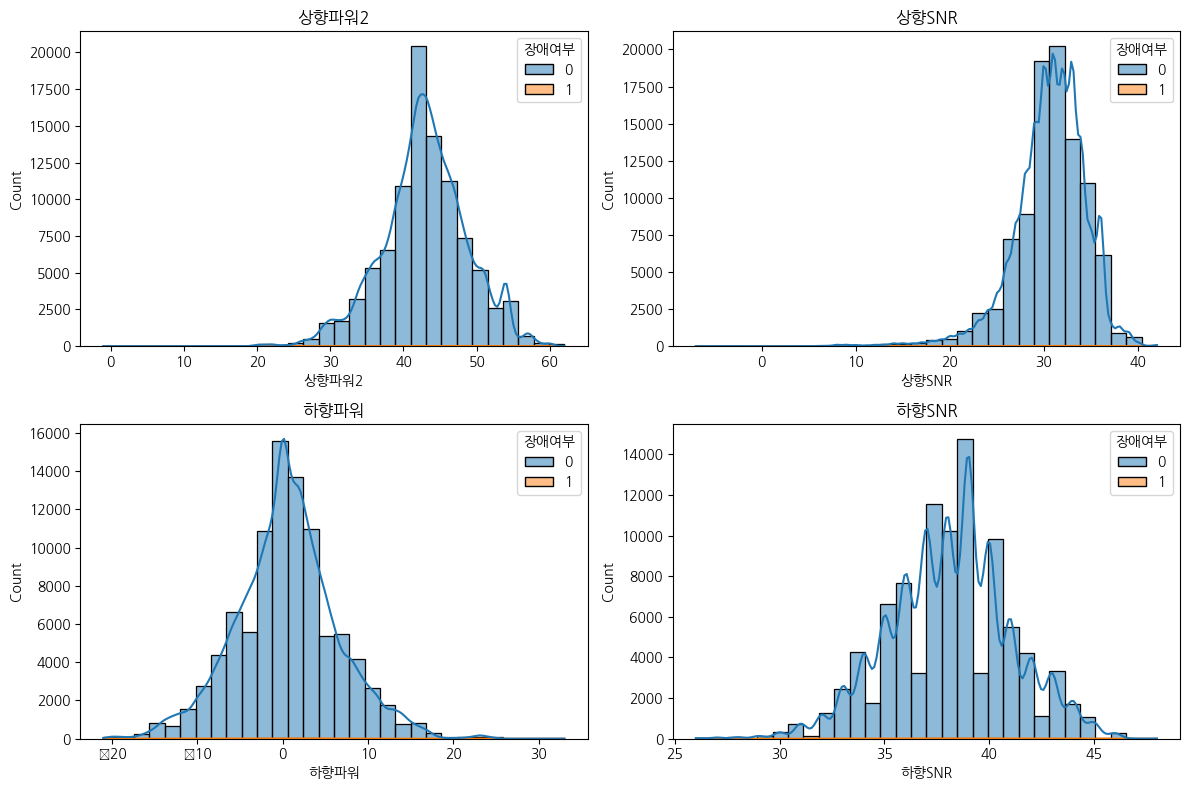

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.rc('font', family='NanumGothic')

plt.subplot(2, 2, 1)
sns.histplot(data, x='상향파워2', bins=30, kde=True, hue='장애여부')
plt.title('상향파워2')

plt.subplot(2, 2, 2)
sns.histplot(data, x='상향SNR', bins=30, kde=True, hue='장애여부')
plt.title('상향SNR')

plt.subplot(2, 2, 3)
sns.histplot(data, x='하향파워', bins=30, kde=True, hue='장애여부')
plt.title('하향파워')

plt.subplot(2, 2, 4)
sns.histplot(data, x='하향SNR', bins=30, kde=True, hue='장애여부')
plt.title('하향SNR')

plt.tight_layout()
plt.show()

In [9]:
# 장애가 발생한 행이 현저히 적음을 확인
data['장애여부'].value_counts()

장애여부
0    95613
1      132
Name: count, dtype: int64

### 4개의 핵심 열에 대한 상자그림 ###

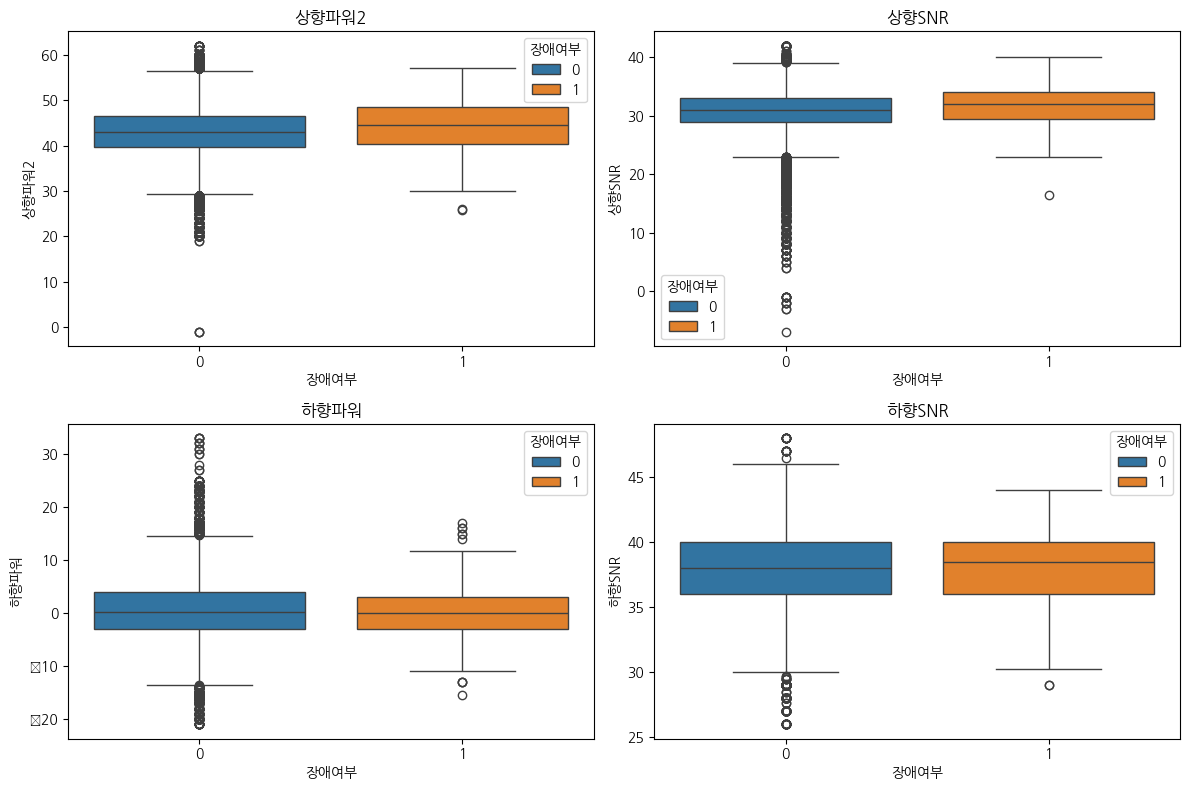

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(data=data, x='장애여부', y='상향파워2', hue='장애여부')
plt.title('상향파워2')

plt.subplot(2, 2, 2)
sns.boxplot(data=data, x='장애여부', y='상향SNR', hue='장애여부')
plt.title('상향SNR')

plt.subplot(2, 2, 3)
sns.boxplot(data=data, x='장애여부', y='하향파워', hue='장애여부')
plt.title('하향파워')

plt.subplot(2, 2, 4)
sns.boxplot(data=data, x='장애여부', y='하향SNR', hue='장애여부')
plt.title('하향SNR')

plt.tight_layout()
plt.show()

### 4개의 핵심 열에 대한 boxenplot ###

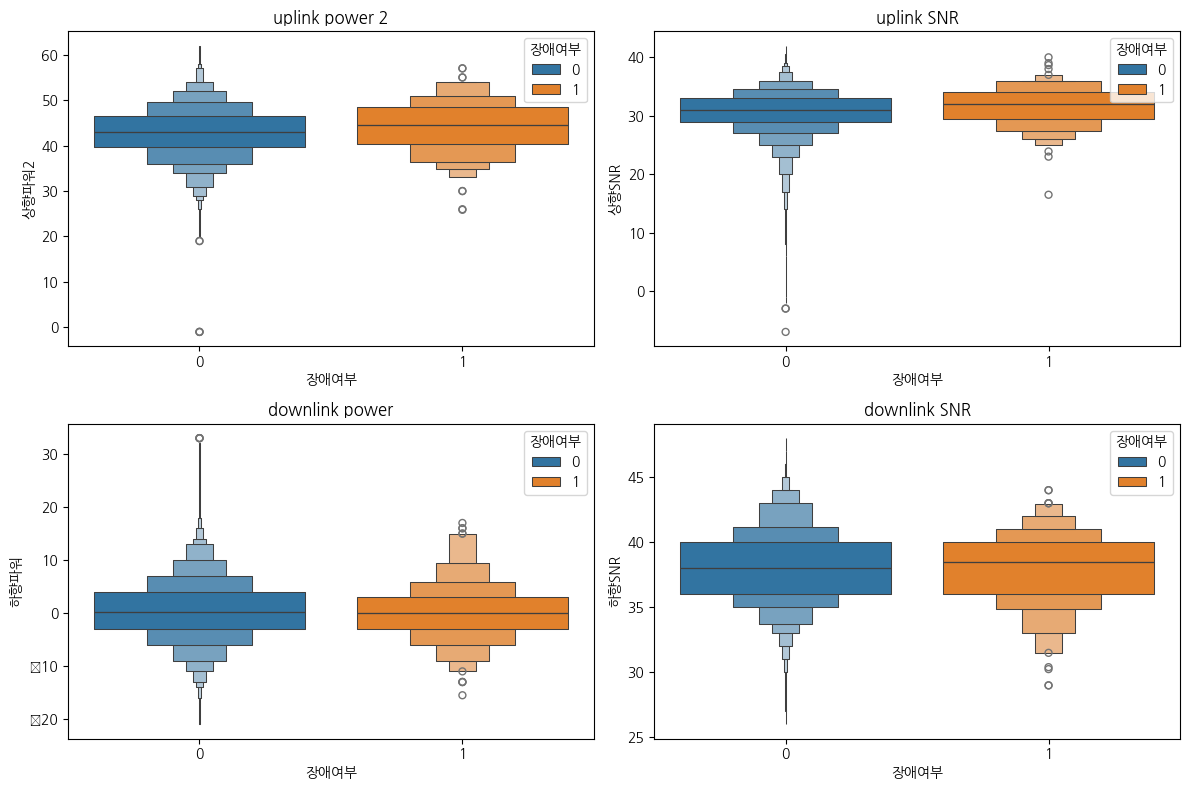

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxenplot(data=data, x='장애여부', y='상향파워2', hue='장애여부')
plt.title('uplink power 2')

plt.subplot(2, 2, 2)
sns.boxenplot(data=data, x='장애여부', y='상향SNR', hue='장애여부')
plt.title('uplink SNR')

plt.subplot(2, 2, 3)
sns.boxenplot(data=data, x='장애여부', y='하향파워', hue='장애여부')
plt.title('downlink power')

plt.subplot(2, 2, 4)
sns.boxenplot(data=data, x='장애여부', y='하향SNR', hue='장애여부')
plt.title('downlink SNR')

plt.tight_layout()
plt.show()

### 새로운 열 cum_rate에 대한 히스토그램, 상자그림, boxenplot ###

4개의 핵심 열 보다 중앙값 차이가 많이 나는 것을 확인
즉 분석 시 영향을 끼칠 수 있다고 판단하여 학습에 포함

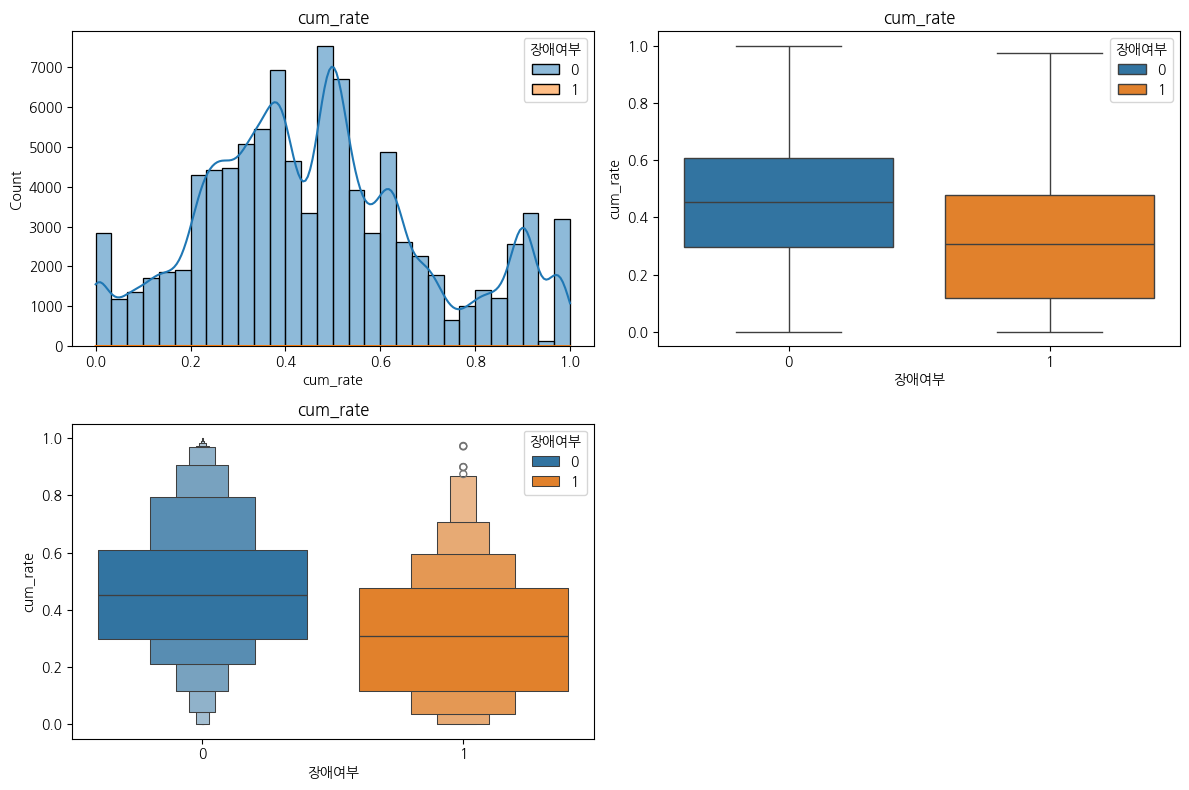

In [12]:
plt.figure(figsize=(12, 8))
plt.rc('font', family='NanumGothic')

plt.subplot(2, 2, 1)
sns.histplot(data, x='cum_rate', bins=30, kde=True, hue='장애여부')
plt.title('cum_rate')

plt.subplot(2, 2, 2)
sns.boxplot(data=data, x='장애여부', y='cum_rate', hue='장애여부')
plt.title('cum_rate')

plt.subplot(2, 2, 3)
sns.boxenplot(data=data, x='장애여부', y='cum_rate', hue='장애여부')
plt.title('cum_rate')



plt.tight_layout()
plt.show()

In [13]:
# 18일 데이터만 추출
f = data[(data['측정시간'] > '2024-04-18 00:00:00') & (data['측정시간'] < '2024-04-19 00:00:00')]

In [14]:
# 장애가 발생한 셀번호 및 장애 발생 횟수 추출
f[f['장애여부'] == 1]['셀번호'].value_counts()

셀번호
YSJBG6-1F      2
YSHS0024       2
YSHS0037       1
YSHS0013       1
YSDG10-1       1
YSHS0054       1
YSHS0042       1
YSHS0047       1
YSHS0046       1
YSHS0070       1
YSHSH5005      1
YSHSHFC0008    1
YSHSHFC0009    1
YSHS0079       1
YSHS0035       1
YSHSHFC0007    1
YSHS0083       1
YSHS0058       1
YSHS0065       1
YSHS0053       1
YSHS0075       1
YSHS0039       1
YSHS0055       1
YSHS0038       1
YSHS0092       1
YSHS0043       1
YSHS0036       1
YSHS0011       1
YSHS0014       1
YSHS0015       1
YSJB5-27       1
YSDGHFC0054    1
Name: count, dtype: int64

In [16]:
# 하나의 셋탑박스 데이터를 가져와서 확인

f[(f['셀번호'] == 'YSJBG6-1F') & (f['장애여부'] == 1)]

,측정시간,온오프라인여부,상향파워2,상향SNR,하향파워,하향SNR,셀번호,total_num,cum_num,cum_rate,장애여부
59706,2024-04-18 10:35:00,onlie,44.5,33.5,1.0,36.0,YSJBG6-1F,2001,1798,0.898551,1
59798,2024-04-18 11:15:00,onlie,46.2,32.4,4.2,30.4,YSJBG6-1F,2005,1802,0.898753,1


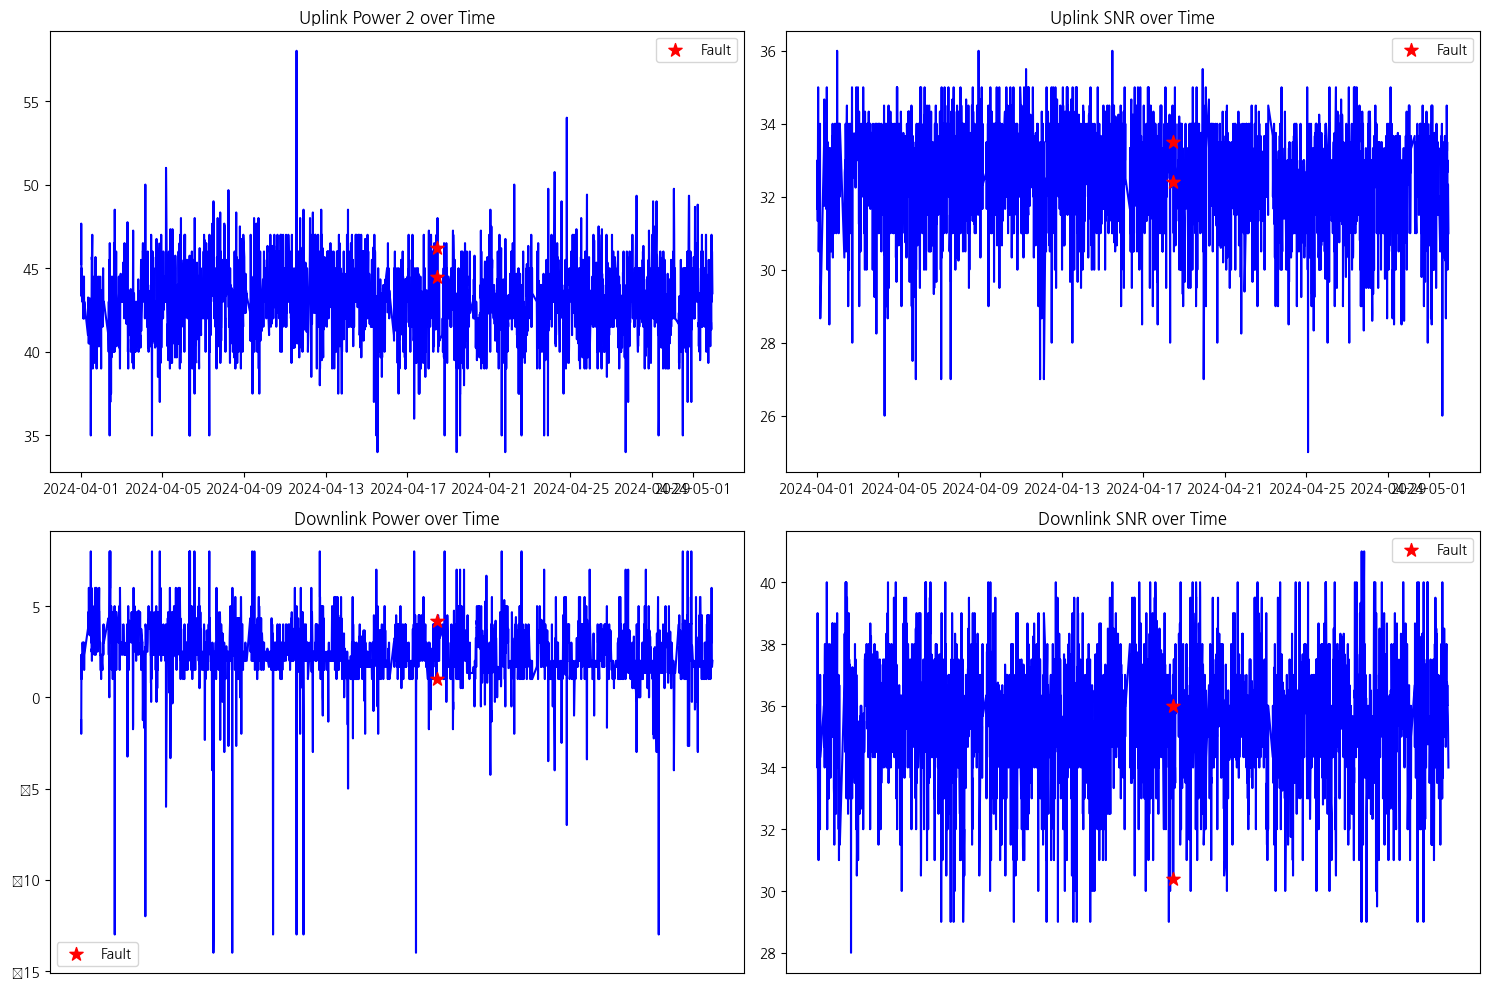

In [19]:
# 전체 기간 그래프화 및 장애 발생 기간 표시

df = data

cell_id = 'YSJBG6-1F'
df_cell = df[df['셀번호'] == cell_id]

df_cell = df_cell.sort_values(by='측정시간')

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.lineplot(x='측정시간', y='상향파워2', data=df_cell, color='blue')
plt.scatter(df_cell[df_cell['장애여부'] == 1]['측정시간'], df_cell[df_cell['장애여부'] == 1]['상향파워2'], color='red', marker='*', s=100, label='Fault', zorder=5)
plt.title('Uplink Power 2 over Time')
plt.legend()
plt.xlabel('')
plt.ylabel('')
# plt.xticks([])

plt.subplot(2, 2, 2)
sns.lineplot(x='측정시간', y='상향SNR', data=df_cell, color='blue')
plt.scatter(df_cell[df_cell['장애여부'] == 1]['측정시간'], df_cell[df_cell['장애여부'] == 1]['상향SNR'], color='red', marker='*', s=100, label='Fault', zorder=5)
plt.title('Uplink SNR over Time')
plt.legend()
plt.xlabel('')
plt.ylabel('')
# plt.xticks([])

plt.subplot(2, 2, 3)
sns.lineplot(x='측정시간', y='하향파워', data=df_cell, color='blue')
plt.scatter(df_cell[df_cell['장애여부'] == 1]['측정시간'], df_cell[df_cell['장애여부'] == 1]['하향파워'], color='red', marker='*', s=100, label='Fault', zorder=5)
plt.title('Downlink Power over Time')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

plt.subplot(2, 2, 4)
sns.lineplot(x='측정시간', y='하향SNR', data=df_cell, color='blue')
plt.scatter(df_cell[df_cell['장애여부'] == 1]['측정시간'], df_cell[df_cell['장애여부'] == 1]['하향SNR'], color='red', marker='*', s=100, label='Fault', zorder=5)
plt.title('Downlink SNR over Time')
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

plt.tight_layout()
plt.show()